## Analyze A/B Test Results

This project will assure you have mastered the subjects covered in the statistics lessons.  The hope is to have this project be as comprehensive of these topics as possible.  Good luck!

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

**As you work through this notebook, follow along in the classroom and answer the corresponding quiz questions associated with each question.** The labels for each classroom concept are provided for each question.  This will assure you are on the right track as you work through the project, and you can feel more confident in your final submission meeting the criteria.  As a final check, assure you meet all the criteria on the [RUBRIC](https://review.udacity.com/#!/projects/37e27304-ad47-4eb0-a1ab-8c12f60e43d0/rubric).

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [43]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

*Eu não vou mudar os nomes das colunas (apesar de ter ficado na tentação), pois parece um exercício guiado*

In [44]:
dfdados = pd.read_csv('ab_data.csv', sep=',', encoding='utf-8', index_col='user_id')

*Interpretando o que temos aqui. É um teste de duas páginas de Webpage, como aquelas da empresa **Audacity**. Então usuários encontram a empresa num mecanismo de busca e são direcionados a uma página oferecendo cursos. O detalhe é que a busca tem um **forking** e ela conduz alguns usuários para a página antiga (**grupo de controle**) e outros para a página novo (**grupo de tratamento**. O usuário lê algumas coisas e se se interessar, irá clicar numa espécie de botão ("adquirir o produto", o que é chamado de **converted**).*

O dataset grava as seguintes informações:

- id do usuário (para saber se não é a mesma pessoa que está entrando duas vezes - pode ter havido um erro no carregamento da página, etc..) - eu quero trabalhar com IDs **únicos**

- timestamp (um formato de data e hora do acesso)

- grupo (**controle** ou **tratamento**)

- página acessada (**antiga** ou **nova**) - informação redundante, pois a do grupo deveria suprir isso!

- convertido (**zero** ou **um**) - a pessoa se **converteu**, ou seja, comprou o produto?

Uma H0 típica de um caso desses seria:

- a taxa de conversão da página **antiga** é igual ou maior do que a taxa de conversão da página **nova**

Uma H1 típica:

- a taxa de conversão da página **nova** é maior do que a taxa de conversão da página **antiga**

In [134]:
dfdados.head(5)

,timestamp,group,landing_page,converted
user_id,,,,
851104,2017-01-21 22:11:48.556739,control,old_page,0
804228,2017-01-12 08:01:45.159739,control,old_page,0
661590,2017-01-11 16:55:06.154213,treatment,new_page,0
853541,2017-01-08 18:28:03.143765,treatment,new_page,0
864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the below cell to find the number of rows in the dataset.

*Costumeiramente eu faço isso:*

In [135]:
dfdados.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 294478 entries, 851104 to 715931
Data columns (total 4 columns):
timestamp       294478 non-null object
group           294478 non-null object
landing_page    294478 non-null object
converted       294478 non-null int64
dtypes: int64(1), object(3)
memory usage: 11.2+ MB


*Mais elegante...*

In [139]:
print ('São {} linhas no dataset'.format(dfdados.shape[0]))

São 294478 linhas no dataset


c. The number of unique users in the dataset.

*Nada como Stack Overflow - eles recomendam fazer literalmente algumas operações, como dropna=True (isso pode me fazer evitar erros no futuro!)*

*Aparentemente alguns usuários visitaram o site várias vezes*

In [4]:
ususing = dfdados.index.nunique() #dropna=True aqui realmente não existem NaNs

print ('São {} usuários singulares'.format(ususing))

São 290584 usuários singulares


### 2/5

d. The proportion of users converted.

Não ficou **perfeito**:
    
- eu tenho alguns usuários repetidos, o cara entrou uma, duas vezes e acabou comprando ou não... na terceira entrada!

*Por que estou insistindo neste pequeno problema deste dataset? Por uma razão simples, se seguirmos a **ortodoxia** da análise Estatística, precisaríamos **eliminar** as diversas entradas de um usuário singular! Por que? Por uma razão muito simples, uma das premissas da inferência é de que os eventos devem ser **independentes**!*

*Depois dá para verificar que este pequeno desvio é passável, pois foi realmente um pequeno número de usuários que fizeram mais de um acesso (e possivelmente à página **nova** e **antiga**). Mas funciona assim: se eu sou um usuário **singular** e muito bem, entro numa máquina... "hmmm, vi, não animei (10% convencido)"... entro de novo... "hmmm, sei, ainda não (30% convencido)"... e entro a terceira vez e faço a compra (100% convencido)! Sabe o que aconteceu? Isso não é como jogar uma moeda **justa**, pois neste caso, dado um usuário, a entrada anterior **condiciona** a posterior! (pois ele possui **memória**)*

*Tudo bem, este é apenas um exercício... mas se formos tratar dados de verdade, temos que atentar aos pequenos detalhes... e que ao final podem ser **fatais**!*

*Mais um comentário, como faríamos em **Física**? Pegamos sempre o **último** resultado para um indivíduo... Dizemos que ele colapsou em $n(t)$... mas isso é mera curiosidade...*

In [163]:
convertidos = dfdados.converted
#convertidos
print('Aderiram em média {} usuários'.format(convertidos.mean()))

Aderiram em média 0.11965919355605512 usuários


*Nada como praticar jeitos diferentes... de grafia... (já me embaralhei demais lendo códigos de terceiros e pensando que eram coisas diferentes!)*

Eu gosto mais de escrever o código o mais **explícito** possível. Me confundo menos:

- resumo da ópera, a diferença neste caso ocorreu na casa **centesimal** da porcentagem (o que seria desprezível)

- no entando, o de baixo deve ser considerado o resultado **real** (o que usamos está ligeiramente distorcido pelas diversas entradas de um mesmo usuário)

In [180]:
compras = dfdados['converted'].groupby(dfdados.index).first() # index.duplicated()
#df3 = df3[~df3.index.duplicated(keep='first')]
len(compras)
print('Aderiram em média {} usuários (resultado mais preciso)'.format(compras.mean()))

Aderiram em média 0.1195695564793657 usuários (resultado mais preciso)


#### parei aqui

e. The number of times the `new_page` and `treatment` don't line up.

In [3]:
a = dfdados[(dfdados['group'] == 'treatment') != (dfdados['landing_page'] == 'new_page')]
print(a.head(4))
a.shape[0]

                          timestamp      group landing_page  converted
user_id                                                               
767017   2017-01-12 22:58:14.991443    control     new_page          0
733976   2017-01-11 15:11:16.407599    control     new_page          0
857184   2017-01-20 07:34:59.832626  treatment     old_page          0
686623   2017-01-09 14:26:40.734775  treatment     old_page          0


3893

f. Do any of the rows have missing values?

`2.` For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to provide how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

*Obs: já fiz isso lá em cima... e também no projeto anterior... e aprendi que isso é bastante enganador! Diria: **aparentemente** está tudo OK!, sem valores **NaN** pelo menos...*

In [26]:
dfdados.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 294478 entries, 851104 to 715931
Data columns (total 4 columns):
timestamp       294478 non-null object
group           294478 non-null object
landing_page    294478 non-null object
converted       294478 non-null int64
dtypes: int64(1), object(3)
memory usage: 11.2+ MB


*Nesses casos, aprendi que usar o método **sample()** é melhor do que **head()**... posso rodar algumas vezes e pegar amostras diferentes...* 

*De onde eu tirei essa filtragem tão certinha? Foi só pular duas questões para frente e fazer minha adaptação!*

In [45]:
#dfaux1 = dfdados[(dfdados['group'] == 'treatment')]
#print(dfaux1.sample(4))
#dfaux2 = dfdados[(dfdados['landing_page'] == 'new_page')]
#print(dfaux1.sample(4))

df2 = dfdados[(dfdados['group'] == 'treatment') == (dfdados['landing_page'] == 'new_page')]
df2.sample(10)

,timestamp,group,landing_page,converted
user_id,,,,
779746,2017-01-14 16:38:30.799186,control,old_page,0
875362,2017-01-22 08:57:20.476754,control,old_page,0
692070,2017-01-10 03:27:16.748518,treatment,new_page,0
928175,2017-01-04 21:12:42.761245,treatment,new_page,0
888106,2017-01-21 02:08:14.522283,treatment,new_page,0
831285,2017-01-04 16:19:42.051384,control,old_page,0
719381,2017-01-21 10:51:44.437210,treatment,new_page,0
857683,2017-01-17 19:43:44.196328,treatment,new_page,0
895448,2017-01-09 03:17:53.107949,control,old_page,1


Ou seja, estão todos os valores **alinhados**:
    
*Eu vi um vídeo sobre **quarta normal** no Youtube e pelo que entendi, seria exatamente esta consistência, dados de uma coluna que dependem de valores de dados de outra coluna, num mesmo dataset.*

In [46]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

*Minha coluna user_id foi definida como meu índice!*

*Quando eu fiz isso, não atentei que poderia se tratar de um dataset problemático, em que uma chave pudesse aparecer mais de uma vez... de qualquer maneira isso é um **defeito** e precisa ser limpo!*

In [12]:
print('Existem {} IDs de usuários únicos'.format(df2.index.nunique()))

Existem 290584 IDs de usuários únicos


b. There is one **user_id** repeated in **df2**.  What is it?

*O valor emergiu como o primeiro na contagem!*

In [47]:
contagem = df2.index.value_counts(sort=True)
#print(contagem)
IDrepetido = contagem.index[0]

print ('O ID repetido :', IDrepetido)

#for indice,dado in contagem:
#    if dado > 1:
#        print(indice)

O ID repetido : 773192


### 3/5

c. What is the row information for the repeat **user_id**?

*Invocando uma variável em filtro com @ [aqui](https://stackoverflow.com/questions/23974664/unable-to-query-a-local-variable-in-pandas-0-14-0)*

In [48]:
#print (IDrepetido)

df2.query('index == @IDrepetido')

,timestamp,group,landing_page,converted
user_id,,,,
773192,2017-01-09 05:37:58.781806,treatment,new_page,0
773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

*Por que manter a última? Repare que as datas foram diferentes, talvez o cara tenha ido e **retornado**! Me parece que a data mais **atual** seria a melhor!*

*Embora isso não tenha adiantado muito. O sujeito visitou duas vezes a página mas não se "converteu", comprando nosso produto...*

*Me enrolei um pouco, mas encontrei boas dicas [aqui](https://stackoverflow.com/questions/13035764/remove-rows-with-duplicate-indices-pandas-dataframe-and-timeseries)*

*O operador lógico de **inversão ~** indica que eu quero todos, ao contrário, do registro duplicado. Eu copiei num banco auxiliar para ter que evitar refazer as tarefas anteriores há cada vez que fazia um teste*

*Consegui este texto explicativo no Slack do curso: It is a unary operator (taking a single argument) that is borrowed from C, where all data types are just different ways of interpreting bytes. It is the "invert" or "complement" operation, in which all the bits of the input data are reversed.*

In [49]:
df3 = df2[~df2.index.duplicated(keep='last')]

#df3 = df3[~df3.index.duplicated(keep='first')]
#df2[df2.index.duplicated(keep= 'last'), inplace=True]
#df2.drop_duplicates(subset='index', keep='last', inplace=True)
#df2 = df2[df2.index.duplicated(keep='first')]

df3.query('index == 773192') #teste no bandido

,timestamp,group,landing_page,converted
user_id,,,,
773192,2017-01-14 02:55:59.590927,treatment,new_page,0


*Copiando de volta ao lugar certo:*

In [50]:
df2 = df3
df2.query('index == 773192') 

,timestamp,group,landing_page,converted
user_id,,,,
773192,2017-01-14 02:55:59.590927,treatment,new_page,0


*Para que este código com if? Se eu quiser mais tarde fazer uma função a partir disso, eu mudo o "Passou" para um*

    return True

In [51]:
duplicatas = df2.index.value_counts()
#duplicatas
#print(duplicatas)
#print(len(duplicatas))

print('Verificando duplicatas :', len(duplicatas[duplicatas > 1]))

if len(duplicatas[duplicatas > 1]) == 0:
    print('Passou')

Verificando duplicatas : 0
Passou


#### Parei aqui

`4.` Use **df2** in the below cells to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [52]:
#df2.head(4)
print ('Média de conversões :', df2['converted'].mean())

Média de conversões : 0.11959708724499628


b. Given that an individual was in the `control` group, what is the probability they converted?

*Sim, é um pouco mais alto... e me parece bastante **pouca** a diferença... mas na direção **errada**!* 

In [53]:
dfcontrole = df2.query('group == "control"')
print(dfcontrole.head(4))
print ('Média de conversões no Controle :', dfcontrole.converted.mean())

                          timestamp    group landing_page  converted
user_id                                                             
851104   2017-01-21 22:11:48.556739  control     old_page          0
804228   2017-01-12 08:01:45.159739  control     old_page          0
864975   2017-01-21 01:52:26.210827  control     old_page          1
936923   2017-01-10 15:20:49.083499  control     old_page          0
Média de conversões no Controle : 0.1203863045004612


c. Given that an individual was in the `treatment` group, what is the probability they converted?

*Desculpe-me, sou como Lázaro... é necessário **ver** para **crer**...*

In [54]:
dftratamento = df2.query('group == "treatment"')
print(dftratamento.head(4))
print ('Média de conversões no Tratamento :', dftratamento.converted.mean())

                          timestamp      group landing_page  converted
user_id                                                               
661590   2017-01-11 16:55:06.154213  treatment     new_page          0
853541   2017-01-08 18:28:03.143765  treatment     new_page          0
679687   2017-01-19 03:26:46.940749  treatment     new_page          1
817355   2017-01-04 17:58:08.979471  treatment     new_page          1
Média de conversões no Tratamento : 0.11880806551510564


d. What is the probability that an individual received the new page?

*Foi tipo: **metade-metade**...*

In [55]:
print ('Probabilidade de ser direcionado à página nova :', (df2.landing_page == "new_page").mean())

Probabilidade de ser direcionado à página nova : 0.5000619442226688


e. Consider your results from a. through d. above, and explain below whether you think there is sufficient evidence to say that the new treatment page leads to more conversions.

**Para mim parece não haver forte indicativo (indícios) de que a página nova realmente produziu mais conversões do que a antiga... os resultados me parecem próximos demais...**

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

$Hipótese_{zero} \rightarrow H_0: p_{new} - p_{old} \leq 0$ (a página **antiga** é tão boa ou melhor do que a nova para "converter")

$Hipótese_{alternativa} \rightarrow H_1: p_{new} - p_{old} > 0$ (a página **nova** é melhor para "converter" pessoas)

- Margem de confiança para erro **Tipo I** (falso positivo): **5%**

*Nada como o bom **codificador LaTex** online [aqui](https://latex.codecogs.com/eqneditor/editor.php)*

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

#### Parei aqui

a. What is the **convert rate** for $p_{new}$ under the null? 

*Qual é a condição **limite** de validade da $H_0$? É que a taxa de "conversões" da nova página é **igual** à da página anterior (ou seja, que a página nova será tão boa quanto a anterior). Então a $p_{nova}$ será igual à $p_{antiga}. Assim, como não faz diferença se estamos na página nova ou antiga...*

In [56]:
dfpnova = df2['converted']
print ('Segundo a H0, a taxa de conversão para a página nova será :', dfpnova.mean())

Segundo a H0, a taxa de conversão para a página nova será : 0.11959708724499628


b. What is the **convert rate** for $p_{old}$ under the null? <br><br>

In [57]:
dfpvelha = dfpnova
print ('Segundo a H0, a taxa de conversão para a página antiga será :', dfpvelha.mean())

Segundo a H0, a taxa de conversão para a página antiga será : 0.11959708724499628


### 4/5

c. What is $n_{new}$?

In [58]:
print(df2.sample(4))
dfnovapagina = df2.query('landing_page == "new_page"')
print(dfnovapagina.sample(2))
print('O número de acessos à nova página foi :', len(dfnovapagina))

                          timestamp      group landing_page  converted
user_id                                                               
941465   2017-01-21 01:46:12.129796  treatment     new_page          1
826610   2017-01-19 20:56:11.462341    control     old_page          0
905407   2017-01-13 14:10:29.391526    control     old_page          0
731861   2017-01-24 08:26:48.732162    control     old_page          0
                          timestamp      group landing_page  converted
user_id                                                               
727717   2017-01-17 10:42:19.003332  treatment     new_page          0
900649   2017-01-23 15:22:44.501361  treatment     new_page          0
O número de acessos à nova página foi : 145310


d. What is $n_{old}$?

In [59]:
dfvelhapagina = df2.query('landing_page == "old_page"')
print(dfvelhapagina.sample(2))
print('O número de acessos à nova página foi :', len(dfvelhapagina))

                          timestamp    group landing_page  converted
user_id                                                             
930918   2017-01-11 00:54:29.230728  control     old_page          0
764849   2017-01-19 12:24:10.000196  control     old_page          0
O número de acessos à nova página foi : 145274


#### Parei aqui

e. Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

A ideia aqui é a seguinte. Eu tenho uma **estatística**, ou seja:

- uma média

- uma quantidade n de elementos

Supondo que eu não tivesse mais aquele dataset original. Eu posso reconstruir um similar, com suas mesmas características **estatísticas**. Em Física, chamaríamos isso de formatar um modelo **granular** a partir de determinadas equações ou condições de existência.

In [60]:
import numpy as np

a = [0, 1] #a minha semente de opções
nnova = len(dfnovapagina)
#print(nnova)
pnova = dfpnova.mean()

new_page_converted = np.random.choice(a, size=nnova, p=[1-pnova, pnova])
print('Nova - meu tamanho amostral original :{}, reconstuído :{}'.format(nnova,
                                                                         len(new_page_converted)))

Nova - meu tamanho amostral original :145310, reconstuído :145310


f. Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [61]:
nvelha = len(dfvelhapagina)
pvelha = dfpvelha.mean()

old_page_converted = np.random.choice(a, size=nvelha, p=[1-pvelha, pvelha])
print('Velha - meu tamanho amostral original:{}, reconstuído:{}'.format(nvelha,len(old_page_converted)))

Velha - meu tamanho amostral original:145274, reconstuído:145274


g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

*Observe que a simulação gerou uma diferença realmente **muito pequena**. Como estamos com o **random choice** aplicado, esta sempre se manterá igual. Mas se o desabilitarmos, poderíamos ver que esse número varia um pouco, podendo eventualmente **zerar**. Isso pode ser chamado de **ruído**. É mais ou menos assim...*

*Eu não tenho certeza de onde este exercício irá levar, mas no curso (**M3, Aula 14**) o instrutor fala: "... **quanto mais coisas você testa, mais provável que você observe diferenças significativas, apenas pelo acaso. Isso acontece quando fazemos avaliações de várias métricas ao mesmo tempo. A probabilidade de falso positivo aumenta conforme você aumenta o número de métricas**...". Bom, o mesmo acontece quando você aumenta demais o número de amostragens... o ruído começa a ser percebido pelo modelo como **significativo**, quando de fato náo é!*

In [62]:
diff = new_page_converted.mean() - old_page_converted.mean()
print('A diferença de probabilidades simuladas para minha nova e velha página é :', diff)

A diferença de probabilidades simuladas para minha nova e velha página é : -0.0010620669658674003


h. Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one you calculated in parts **a. through g.** above.  Store all 10,000 values in a numpy array called **p_diffs**.

*Cuidado: isso demora muito para rodar!*

In [23]:
def embaralhador(nnova, nvelha, pnova, pvelha, tamanho, a=[0,1]):
    import numpy as np
    captadiff = []

    for i in range(tamanho):
        new_sample = np.random.choice(a, size=nnova, p=[1-pnova, pnova])
        old_sample = np.random.choice(a, size=nvelha, p=[1-pvelha, pvelha])
        captadiff.append(new_sample.mean() - old_sample.mean())

    return np.array(captadiff)
    
nnova = len(dfnovapagina)
pnova = dfpnova.mean()
nvelha = len(dfvelhapagina)
pvelha = dfpvelha.mean()
    
p_diffs = embaralhador(nnova, nvelha, pnova, pvelha, 10000)

Pareceu OK:

- gerou uma lista com 10.000 posições em ponto flutuante, representando as diferenças

In [132]:
print(p_diffs)
print(len(p_diffs))
p_diffs[0]

[-0.00065689 -0.00066359  0.0013392  ... -0.00073949  0.00032063
 -0.00077361]
10000


-0.0006568860245934893

In [24]:
np.save('matrizdiff.npy', p_diffs)

In [25]:
df2.to_csv('abdf2.csv', sep='\t', encoding='utf-8', index=False)

#### Parei aqui

Truque do preguiçoso: busquei na documentação do numpy como gravar um binário com os valores gerados para continuar mais tarde...

In [26]:
import numpy as np

In [63]:
p_diffs = np.load('matrizdiff.npy')

In [64]:
p_diffs

array([-0.00065689, -0.00066359,  0.0013392 , ..., -0.00073949,
        0.00032063, -0.00077361])

In [33]:
df2 = pd.read_csv('abdf2.csv', sep='\t', encoding='utf-8', index_col=False)
df2.head(2)

,user_id timestamp group landing_page converted
0,851104\t2017-01-21 22:11:48.556739\tcontrol\to...
1,804228\t2017-01-12 08:01:45.159739\tcontrol\to...


i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

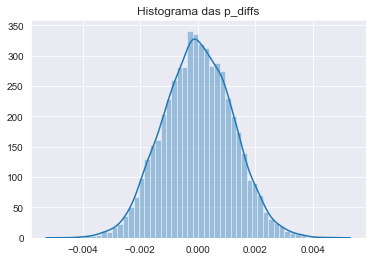

In [27]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("darkgrid") 
sns.distplot(p_diffs).set_title('Histograma das p_diffs'); #<-esse ; elimina aquela linha de chamada horrorosa

#código descartado (eu posso precisar dele, se algo der errado!)
#plt.ioff()
#seaborn.distplot(a, bins=None, hist=True, kde=True, rug=False, fit=None, 
#                 hist_kws=None, kde_kws=None, rug_kws=None, fit_kws=None
#                 color=None, vertical=False, norm_hist=False, axlabel=None, label=None, ax=None)

#plt.hist(p_diffs) #ficou horroroso, vamos para o Seaborn!

Queremos a diferença da média de conversões ocorridas na página nova e na antiga:

-0.0015790565976871451


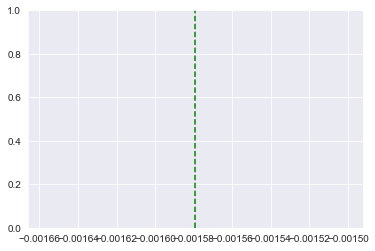

In [77]:
#fizemos essas coisas lá em cima...
dfnovo = df2.query('group == "treatment"')
medconvnovo = dfnovo.converted.mean()

dfvelho = df2.query('group == "control"')
medconvvelho = dfvelho.converted.mean()

diffobservada = medconvnovo - medconvvelho
print(diffobservada)

#plt.axvline(x=obs_diff, color='red');
plt.axvline(x=diffobservada, linestyle = '--', color='g');

Juntando as coisas...

*Bom, eu espeava essa linha verde aí bem no **centro** da minha curva de distribuição normal...*

*Pensando bem, o azulzinho veio de uma simulação computacional, o verdinho veio de um outro dataset, que é o do experimento real...*

*Se eu não estivesse com meu gerador de números aleatórios travado em um set de geração, eu aposto como se se fosse rodando esta simulação várias vezes, iria ver essa barra verde "passeando" pelo gráfico de distribuição normal... eu posso dizer que sei qual é o problema aqui: é **ruído**! Estou lidando com um conjunto de amostras **muito grande** e como dito em aula, o ruído pode nos pregar alguns truques!*

---

*A propósito, ando penando mais do que esperava para gerar meus gráficos... então estou adquirindo o tutorial da Datacamp de plotagens no Seaborn (o Pyplot sempre me deu surpresas horríveis!)* 

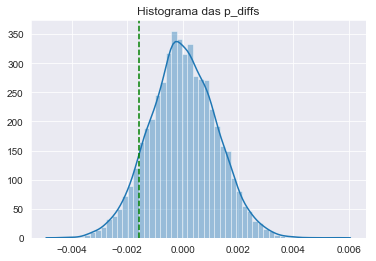

In [72]:
bsns.set_style("darkgrid") 
sns.distplot(p_diffs).set_title('Histograma das p_diffs')
plt.axvline(x=diffobservada, linestyle = '--', color='g');

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

Isso daqui tem cara de **valor-p**...

In [75]:
(p_diffs > diffobservada).mean()

0.9106

k. In words, explain what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

Primeiro, com relação a **Teste de hipóteses estatísticas**, existe o conceito de:

- **Nível de significância** que é a probabilidade de se observar resultados amostrais tão ou mais extremos do que aqueles observados, considerando-se $H_{0}$ verdadeira (nossa **premissa inicial**). Se esta probabilidade for pequena, concluímos que há provas suficientes para rejeitar $H_{0}$. Para isso a abordagem:

 - **Nível de significância observado - **valor-P** 
 
   - **primeiro** a estatística teste é calculada usando-se dado amostral
   
   - **então** a distribuição de probabilidade apropriada é usada para encontrar a probabilide de se observar uma estatística amostral que seja pelo menos **um pouco** diferente do valor da $H_{0}$ para o parâmetro populacional (**valor-P**)
   
   - (lembrando que quanto **menor o valor-p, melhor a prova contra $H_{0}$
   
(fonte: **Resumão de Estatística** (texto ligeiramente modificado) - nada como uma visita na Livraria Cultura no feriadão do Carnaval...)

Bom, o valor-p foi calculado, apontando a proporção dos valores da distribuição nula que foram maiores do que a diferença observada nos dados reais.

Meu valor-p ficou **bem acima** da nossa taxa de aceitação de 5% esperado para erro do Tipo I (**falso positivo**, ou **rejeitar** a $H_{0}, sendo ela **verdadeira**).

Assim podemos afirmar que:

- falhamos em rejeitar a $H_{0}

- não há evidências que comprovem que a nova página produz mais conversões do que a primeira

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [65]:
dfnovo2 = df2.query('landing_page == "new_page"')
medconvnovo = dfnovo2.converted.mean()

dfvelho2 = df2.query('landing_page == "old_page"')
medconvvelho = dfvelho2.converted.mean()

convert_new = dfnovo2['converted'].sum()
convert_old = dfvelho2['converted'].sum()
print (convert_old, convert_new)

n_new = len(dfnovo2)
n_old = len(dfvelho2)
print (n_old, n_new)

17489 17264
145274 145310


m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

O link indicado não funciona, o site não existe mais! Mas no Statsmodels, encontrei [aqui](https://www.statsmodels.org/dev/generated/statsmodels.stats.proportion.proportions_ztest.html) algumas dicas bastante claras sobre o uso do método **proportions_ztest()**

---

        .stats.proportions_ztest(count, nobs, value=None, alternative='two-sided', prop_var=False)

- **count** – the number of successes in nobs trials. If this is array_like, then the assumption is that this represents the number of successes for each independent sample

- **nobs** – the number of trials or observations, with the same length as count

---

- **alternative** – The alternative hypothesis can be either two-sided (**não é meu caso**) or one of the one-sided tests

- In the two sample test:

 - smaller means that the alternative hypothesis is **prop < value** (p1 < p2) (**não quero isso**)
 
 - larger means **prop > value** (p1 > p2 - where p1 is the proportion of the first sample and p2 of the second one)

---

Returns:	

- **zstat** – test statistic for the z-test
- **p-value** – p-value for the z-test

*Fonte: Statsmodels (levemente adaptado para meu contexto)*  

In [97]:
import statsmodels as sm #.api.stats.proportions_ztest as sm
sm.__version__

'0.9.0'

In [98]:
dir(sm.stats)

AttributeError: module 'statsmodels' has no attribute 'stats'

In [ ]:
from scipy.stats import norm

In [76]:
#sm.stats.proportion.proportions_ztest(count, nobs, 
#                                      value=None, alternative='two-sided', prop_var=False
valores = sm.stats.proportions_ztest([convert_new, convert_old], [n_new, n_old], 
                                     alternative='larger')
#isso me traz uma tupla (teste-z, valor-p)
print('teste z (unicaudal): ', valores[0])
print('valor-p (unicaudal): ', valores[1])

AttributeError: module 'statsmodels' has no attribute 'stats'

---

Isso tem a ver com **Estatística-T**

Dada uma curva de distribuição **normal**, nós podemos inferir áreas sob esta curva, cruzadas por pontos de probabilizade $z$.

*Antigamente tínhamos tabelas para fazer isso. Então eu peguei o meu **Resumão de Estatística**, coloquei lá **Teste Unicaudal**, com **Nível de Significância A = 0.05** (este A me diz que é um teste **unilateral**, ou **unicaudal**). Muito bem, eu quero a rabeira da curva, com **GL = inf** (graus de liberdade infinitos, ou maior do que 30) e chego a:

- $\alpha = 1.645$

#### Como calcular valores críticos

**Cumulative Density Function (CDF)**: Returns the probability for an observation equal to or lesser than a specific value from the distribution.

**Percent Point Function (PPF)**: Returns the observation value for the provided probability that is less than or equal to the provided probability from the distribution (o contrário do CDF - é o que eu procuro!)

*Conceitos encontrados [aqui](https://machinelearningmastery.com/critical-values-for-statistical-hypothesis-testing/)*

---

In [101]:
estatistica = 0.95
alpha = norm.ppf(estatistica)
print('alfa: ', alpha)

alfa:  1.6448536269514722


n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

Eu tenho:

- um teste **unicaudal**

- um $\alpha$=1.645$ (meu valor crítico para este teste)

Eu tive comos resultados:

- Escore-Z de **-1.31** (abaixo do meu $\alpha$ - e localizado **antes** do meu ponto central da distribuição normal)

- Valor-P de **0.91** (acima de 0.05, ou 5%)

Com estes resultados, novamente **falhamos** em rejeitar $H_{0}$

Em outras palavras, $H_{0} continua **válida**, ou seja, que a página **anterior** era **tão boa** (ou até melhor) do que a página **nova**, em produzir conversões.

#### Parei aqui

### 5/5

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you acheived in the previous A/B test can also be acheived by performing regression.<br><br>

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

Segundo o curso, a regressão que melhor se adapta à conversão de [0, 1], tipo sim/não é a regressão **logística**. O que faz sentido, pois ela é altamente **dispersiva**, ou seja, qualquer afastamento do seu núcleo central leva a uma decisão. No caso, o sim/não pode ser interpretado como uma variável **categórica**

Uma explicação melhor para variáveis dummie se encontra [aqui](https://en.wikipedia.org/wiki/Dummy_variable_(statistics)). Historicamente, máquinas de **babbage** eram programadas com fitas perfuradas (na verdade eram teares automatizados). Quando você tem uma categoria com n tipos diferentes, matematicamente a melhor forma é tratar cada tipo como sendo uma **feição** diferente. Assim, testa-se uma a uma quais as alterações que ela causa no nosso modelo. Faz sentido.

*Eu vi muitas traduções para variável dummie. O mais parecido para mim seria indicator variable, ou seja **variável indicativa**, ou **variável de indicação**.*

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives.  

However, you first need to

- create a column for the intercept, and 

- create a dummy variable column for which page each user received.  

Add an **intercept** column, as well as an **ab_page** column, which is 

- 1 when an individual receives the **treatment** and 

- 0 if **control**.

Eu preciso criar a variável dummie, com 0 para **control** e 1 para **treatment**

In [88]:
#df[['no_fraud', 'fraud']] = pd.get_dummies(df['fraud'])
#df = df.drop('no_fraud', axis = 1)

df2[['control', 'treatment']] = pd.get_dummies(df2['group'])
df2.head(4)

,timestamp,group,landing_page,converted,control,treatment
user_id,,,,,,
851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
661590,2017-01-11 16:55:06.154213,treatment,new_page,0,0,1
853541,2017-01-08 18:28:03.143765,treatment,new_page,0,0,1


In [89]:
df2 = df2.drop('treatment', axis = 1)
df2.head(4)
#df2['ab_page'] = pd.get_dummies(df2['group'])['treatment']

,timestamp,group,landing_page,converted,control
user_id,,,,,
851104,2017-01-21 22:11:48.556739,control,old_page,0,1
804228,2017-01-12 08:01:45.159739,control,old_page,0,1
661590,2017-01-11 16:55:06.154213,treatment,new_page,0,0
853541,2017-01-08 18:28:03.143765,treatment,new_page,0,0


In [91]:
#Criar o intercept
df2['intercept'] = 1
df2.head(4)

,timestamp,group,landing_page,converted,control,intercept
user_id,,,,,,
851104,2017-01-21 22:11:48.556739,control,old_page,0,1,1
804228,2017-01-12 08:01:45.159739,control,old_page,0,1,1
661590,2017-01-11 16:55:06.154213,treatment,new_page,0,0,1
853541,2017-01-08 18:28:03.143765,treatment,new_page,0,0,1


c. Use **statsmodels** to import your regression model.

- Instantiate the model, and

- fit the model using the two columns you created in part **b.** to predict whether or not an individual converts.

Instanciando:

In [45]:
#sm.Logit(df['fraud'], axis=1) #o primeiro argumento é a resposta
#logit_mod = sm.Logit(df['fraud'], df[['intercept', 'duration']])




#log_mod = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])

NameError: name 'df' is not defined

Ajustando:

In [ ]:
results = logit_mod.fit()
results.summary

#results = log_mod.fit()

Lembretes da aula de logística:

- provavelmente não usarei, mas posso precisar!

In [ ]:
# eu preciso exponenciar o coeficiente da duração
np.exp(-1.4637) #para cada unidade aumentada na duração, fraude é 0.23 mais provável

#o recíproco
1/np.exp(-1.4637) #4.32 vezes menos provável para cada unidade diminuída na duração

#e o do weekday
np.exp(2.5465) #12.75 vezes mais comum nos dias de semana do que nos finais de semana

d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [ ]:
results.summary()

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in the **Part II**?

In [ ]:
O p-valor associado com ab_page é 0.19. Ele se difere do valor encontrado na parte II porque o teste aqui é bicaudal enquanto o teste de lá foi unicaudal.

Abaixo podemos simular um Z-teste bicaudal e chegaremos num p-valor semelhante:
# Simulando um Z-teste bicauldal com os mesmos valores da parte II
z_score, p_value = sm.stats.proportions_ztest([convert_new, convert_old], [n_new, n_old])
alpha = norm.ppf(1-(0.05/2))
print('z-score: ' + str(z_score))
print('p_value: ' + str(p_value))
print('alpha: ' + str(alpha))

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

Às vezes a adição de outras **feições** (perfil etário, conversões anteriores - identificar se a pessoa já é cliente, grupos de interesse) podem influenciar as decisões atuais, de converter ou não. Um modelo suficientemente rico, mas não rico o suficiente para tentar "modelizar tudo" parece ser o que produz os mehores resultados.

Agora imagine que eu vá adicionando novas e novas feições a meu modelo. E coisas como a cor da camisa, ou o modelo da bicicleta, ou se a pessoa costuma passar o feriado de final de ano na praia... espere, isso é **realmente** relevante?

Às vezes não. Algumas pessoas que compram aquele automóvel com ar condicionado usam camisa branca, outros de lista... e no nós temos um monstro com n feições e muitas delas com **valor-p** elevado...

Num mundo ideal eu poderia ter montes e montes de entulho (desde que minha casa fosse realmente grande). Mas na prática o que acontece? Essas coisas vão me gerando **ruído** e distorcendo o modelo e logo eu passo a recomendar que vendedores insistam em vender o **ar condicionado**, caso o meu cliente esteja vestindo a **camisa branca**... o que é isso no fundo? O surgimento de um **falso positivo** e que pode me colocar em situações realmente constrangedoras... 

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives. You will need to read in the **countries.csv** dataset and merge together your datasets on the approporiate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [ ]:
df2 = pd.read_csv('abdf2.csv', sep='\t', encoding='utf-8', index_col='user_id')

In [ ]:
countries_df = pd.read_csv('./countries.csv', sep=',', encoding='utf-8', index_col='user_id')

In [ ]:
df_new = countries_df.set_index('user_id').join(df2.set_index('user_id'), how='inner')

df_new.country.value_counts()
df_new.head()

In [ ]:
### Create the necessary dummy variables
df_new = df_new.join(pd.get_dummies(df_new.country))
df_new.head()

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [ ]:
### Fit Your Linear Model And Obtain the Results
log_mod = sm.Logit(df_new['converted'], df_new[['intercept', 'UK', 'US']])

log_mod = sm.Logit(df_new['converted'], df_new[['intercept', 'ab_page', 'UK', 'US']])

results = log_mod.fit()
results.summary()

Adicionamos toda uma **dimensão** ao nosso modelo, acrescentando a informação **países**. Parece pouco? Pense que se formos adicionando e adicionando novas dimensões, qual a complexidade (e o ruído produzido) que atingiremos.

Se a dimensão fosse **relevante**, OK. Mas ao que parece, valor-p acima do crítico de 5% mostra que a nova feição não ajudou a explicar o fenômeno das conversões. Então neste caso, recomenda-se **não manter** a nova feição. 

## Conclusions

---

#### Conclusão geral

Com relação aos testes realizados, não houve evidência suficiente para rejeitar a hipótese nula e a nova página não deveria ser colocada em produção. Testado por:

- distribuição amostral

- regressão linear

#### Possíveis distorções

Os testes podem ter sofrido algumas **distorções** que poderiam alterar seus resultados (efeito do tempo, efeito da novidade, etc..)

Ao invés de apenas citar potenciais **distorções**, citando as da classe,  resolvi criar uma lista bastante complexa de fenômenos que poderiam gerar distorções. E algumas delas podem ser muito benéficas para nossa nova estrutura. Isso extrapola o conteúdo dos testes A/B e se baseia fortemente em estudos de **Teoria Geral de Sistemas** e em **Cibernética**. Seguem alguns deles (dos fáceis aos mais complexos para o final):


- **grupo de usuários que realizou os testes pode não ter sido o mesmo do que o grupo de usuários que irá fazer a compra**. Às vezes empresas colocam seus próprios funcionários, professores os seus alunos e programadores, os seus amigos (também programadores) para fazer testes em páginas Web. Bom, isso não é muito confiável, pois o domínio de crenças, as esferas de valores, a capacidade econômica e outros fatores explicados pela **Teoria dos Jogos** podem explicar distorções não hora de se se simular/comprar (eu posso arriscar 1 bilhão em ações num simulador e não ter coragem de comprar um título de R$5.000,00 num banco e que envolva risco!)

- **tempo do teste insuficiente** - Às vezes coisas levam um tempo para se estabilizar. Pessoas acostumadas com o antigo "site" se sentem constrangidas no novo (ou o contrário) e são tentadas a comprar mais, ou menos do que ao longo do tempo. As pessoas terão talvez que se acostumar com a nova plataforma

- **engodo do "estouro de vendas"** - (um exemplo disso é o **erro da promoção**: uma loja não está vendendo bem e resolve fazer uma "queima de estoque". Então aparecem muitos e muitos compradores. Tudo volta a se estabilizar e as vendas com o passar dos meses, se nota que estão **abaixo** das da queima... por quê? Está todo mundo esperando o novo "queimão"!)

- **mercadorias tendenciosas** - Eu vendia muito bem no meu antigo "site" um "Eau de Parfum" que custa 500 o frasco de 50ml. No novo "site" eu vendo melhor uma "Eau de Toilette" que custa 125 o frasco de 250ml. Só que a minha margem de lucro nas antigas vendas era consideravelmente melhor! (Às vezes estamos em um **franja de mercado** e mesmo ao custo de vender pouco, evitamos uma concorrência desnecessária com *O Boticário*, para dar um exemplo

- **mudança de freguesia** - Pronto, eu peguei um público mais jovem e arrojado... isso é mal? Não necessariamente! mas é o mesmo problema do ítem **anterior** (Se eu conseguir permissão para acessar o perfil do *Facebook* do meu cliente, isso seria talvez o sonho!)

- **custo da rejeição é maior do que o ganho da promoção** - Isso recentemente virou uma discussão envolvendo entre outras coisas **eleição presidencial** (não entrando no mérito, pois aqui isso é **irrelevante**!)... se a antiga estrutura me causava pouca rejeição, mas poucas vendas... a estrutura nova me causa muitas vendas mas maior rejeição... isso é uma balança **delicadíssima** e que pode me custar o meu comércio fechar as portas em um futuro próximo... altas taxas de rejeição, seja lá no que for, tendem a dar **Efeito de Memória** e criar maiores e maiores rejeições a longo prazo...

- por falar em efeito de memória... vale a pena citar **Fenômeno de Aniversariamento** - Aniversariamento é um fator da memória humana muito estudado por psiquiatras e analistas do comportamento humano. Basicamente funciona assim: num país hipotético, um presidente hipotético mudou o padrão monetário para $Cruzado$ a fim de evitar inflação galopante. Junto com este pacote, que a princípio foi **bem recebido** pela população, o gentil homem teria feito um confisco de poupança hipotético, que gerou grande instatisfação e consequentemente, uma movimentação popular que o levou a perder o cargo de presidência hipotética. O que aconteceria se um novo presidente, para conter evolução inflacionária propusesse mudança no padrão monetário? Quase que certamente uma **revolta popula imediata e sem precedentes**. Qual a razão? **Fenômeno de Aniversariamento**. E isso poderia ocorrer, caso tentássemos diversos "sites" novos e problemáticos para nossa **Audacity**...

- **Efeito Zeitgeist** ("Espírito do Tempo") - Era moda no entre-guerras a moda "Prêt-a-porter" (pronta para sair), um estilo provocante e inovador da mulher jovem dizendo: "meus pais não me seguram mais, acabou a guerra e com ela, a tradição...". A escola Bauhaus foi considera **socializante e escandalosa** e em 1933, foi fechada à força por uma sociedade que buscava valores mais... "tradicionais" na Alemanha Nazista... E hoje a maioria do nosso mobiliário possui **forte inspiração** na Bauhaus! Então nosso "site" pode receber mais conversões agora por "ser vintage" e alguns anos depois ser considerado "boco-moco" pela maioria dos seus usuários... mesmo sem **nenhuma** modificação!

- **Efeito Repertório** - É um outro fenômeno estudado por psiquiatras e analistas de comportamento. Pessoas com uma cultura mais limitada (independendo se vieram de castas economicamente mais favorecidas, ou de regiões consideradas mais ricas de um país), quando são expostas a **situações novas** tendem a ficar sem ação, ou mesmo entrar em desespero. Suponha um exemplo de dois engenheiros. Ambos fizeram faculdade de Engenharia, se formaram e foram trabalhar. Mais tarde houve uma crise fenomenal e ambos ficaram sem emprego... o detalhe é que um deles aprendeu o ofício de **marcenaria** na sua juventude e com isso conseguiu pagar as contas fazendo banquinhos para vender na feira... um **indígena** ou um **quilombola** pode ter mais repertório do que um cidadão moderno médio e isso pode lhe dar mais chances de adaptação/sobrevivência em condições extremas... bom, se eu trabalho com um público de **pouco repertório**, qualquer mudança tenderá a ser mal vista e criticada, mesmo que seja para o bem... como saber se meu público é assim? Isso demanda análises mais apuradas e complexas...

- **Efeito Aprendizado** - Ao longo do tempo, eu aprendo a corrigir e a limar meu "site" e a manutenção passa a custar pouco e ser mais fácil... já o meu novo "site" funciona mais como um **protótipo** de um avião ou de um automóvel... ele tende a me dar mais problemas, a estar com mais arestas... tudo isso desagrada o usuário... mesmo que ao final meu produto seja muito melhor!

- **Efeito Vaca Sagrada** - Na Índia, as vacas eram consideradas animais sagrados. Mas um proprietário de uma empresa, ou antigos diretores com muita voz na decisão podem dizer "Ah... isso não é negociável! Isso é **sagrado**!". Então pronto, nós temos algumas feições do nosso projeto que são **inalteráveis** (e que podem tornar muito cara minha mudança para o novo "site")

- **Efeito Ação Imediata** - Se percebeu que quando colocado sob pressão, o ser humano costuma a optar por ferramentas intelectuais mais primitivas e que dão respostas mais imediatas. Assim, se eu tenho que montar um caixote de madeira e tenho meu final de semana para isso, primeiro eu abro minha latinha de cerveja, separo as ferramentas (chave de fenda, furadeira, parafusos para madeira, cola...), faço as medições, desenho no papel... agora se é para um "se vira nos 30!", eu nem consigo pensar direito, vai ser no serrote, prego e martelo! Então, se eu induzir meu cliente a executar sua compra na tela "promoção relâmpago: 30 segundos", eu possivelmente acionarei partes mais primitivas do cérebro dele e ele provavelmente fará a compra... e 15 minutos depois estará me ligando para cancelar por arrependimento! Má estratégia! Se meu "site" novo se basear nesta ação, estarei perdido...

- **Efeito em Cadeia** - Um curso leva a outro e isso leva a outro... e a um programa de fidelização... Se meu "site" novo refletir melhor isso, eu poderei esperar lucros maiores e seguros... num horizonte temporal maior. É difícil de modelizar isso... mas suponha que minha **Audacity** agora oferece um determinado curso hipotético chamado **Fundamentos em Data Science II** a ser feito como continuação do...

- **Perfis Estratégicos** - Em **Teoria dos Jogos** temos jogadores **Aversos ao Risco**, **Neutros ao Risco**, etc.. No comércio, vendedores costumam classificar pessoas como **Apoiador**, **Meticuloso**, **Realizador** e **Expressivo**. Às vezes o novo "site" agrada a um desses grupos, mas causa problemas com os outros!

- **Jogo do Prisioneiro** - Um clássico problema de **Teoria dos Jogos**, uma determinada pessoa, sem saber qual foi a decisão das demais, é levada a "converter" ou "não converter", segundo um cálculo de riscos e benefícios potenciais. A **Audacity** poderia usar uma estratégia deste tipo na sua nova página...

- **Tac-for-Toe** ou "jogo da manipulação"- Analisando comportamento de pássaros, se descobriu que é muito frequente que um deles, para induzir determinado comportamento nos demais, faça uma determinada ação. Então meu novo "site" me "oferece uma minhoca", na esperança de que o cliente faça o mesmo no seu turno. É um comportamento complexo e que em alguns casos, dá muito certo (golpistas e fraudadores costumam usar com frequência desta tática, mas ela poderia ser usada para o bem).

- **Efeito Titanic** - Eu já investi 100 mil na minha antiga página da **Audacity**... como eu justificarei isso para meus diretores? Não seria melhor gastar os 20 mil para deixá-la ainda melhor? Nem é necessário explicar muito, mas o **Efeito Titanic** costuma causar muitas distorções na hora de avaliar resultados **reais**, como a do desempenho da minha nova plataforma...

- **Efeito de Clã** - Eu uso um jargã próprio (como num grupo hipotético de Twitter envolvendo **Floofer**, **Doggo**...) e com isso eu atraio apenas pessoas do meu próprio clã. Isso pode ser bom ou muito **prejudicial** (o que normalmente é) nas feições do meu novo "site"...

- **Efeito Iniciático** - O meu aluno do meu novo "site" é compelido a se sentir um "iniciado", com provas de iniciação e tudo mais na minha nova estrutura... e ele é compelido a comprar novos produtos, cada vez mais complexos e caros... (isso parece extremamente **maléfico**, mas nem sempre! - às vezes a sociedade acaba reconhecendo o aluno da **Audacity** como um cara valoroso para se ter numa empresa e os ganhos individuais podem superar e muito o valor investodo...)

- **Efeito Moby Dick** - Inspirado no romance de Herman Melville, um indivíduo (o capitão Ahrab) se torna, após um trauma (perda de uma perna), tão obstinado a eliminar um determinado cachalote (Moby Dick) que acaba levando seu navio e tripulaão ao desastre. Em alguns casos, o meu "site" pode resultar em ações muito diversas do esperado, ao expor seus integrantes a situações traumáticas (como um hipotético curso imenso de **Data Science 2** e que parece não ter mais fim!)

- **Efeito Dominó** - Minha nova página altamente promocional, oferecendo aquele curso dos sonhos por "apenas R$5,00" fez com que a *Udemy*, a *Udacity*, meus concorrentes, a fazerem o mesmo. Resultado: um leilão de cursos baixos que fará todo mundo perder dinheiro (e os mais fracos a falirem). Os pontos de equilíbrio de **Nash**, em **Teoria dos Jogos** ajudam a descrever este e outros efeitos de grupo e que podem ter resultados terríveis.

- **Hipnose** - Não se sabe exatamente como ela funciona. Aparentemente algumas pessoas já são **sugestionáveis** para tomar determinado tipo de ação. Foram feitos testes exaustivos neste tema nos anos 60 e 70 e nunca se chegou a uma conclusão clara (pessoas fortemente hipnotizadas foram apresentadas a um copo de água comum, que lhes afirmaram conter um ácido terrível. Elas agiram de maneira compatível à sugestão e quando pedidas a **arremessar o ácido** ao rosto de outra pessoa, elas o faziam com facilidade. No entanto, quando aparecia uma pessoa com luvas e máscara e enchia com cautela um segundo copo de solução salina parecida com ácido de verdade, o que ocorria era invariavelmente a pessoa sair do **transe hipnótico**). Explorar estes efeitos num site da **Audacity**? Isso poderia custar **boas risadas** ou um enorme **processo judicial**. É anti-ético manipular pessoas! (embora diversas seitas façam isso a todo momento!).

- **Teoria da Guerra** - Um dos campos pouco estudados na Teoria dos Jogos. Mas o importante ao final é **ganhar todas as batalhas**, **subjugar e humilhar o oponente**, **não sofrer muitos danos** ou **estabelecer a paz a qualquer preço**? Ao criar uma nova plataforma em um mercado competitivo, a nossa **Audacity** terá que lidar com todos esses dilemas. E isso não é explicado por um simples **Teste de Hipóteses**... 

*(Tirado a grosso modo dos meus estudos em Sistêmica, na leitura da "Enciclopédia Internacional de Cibernética e Sistêmica", de Charles François, 2 vols.)*

Tudo isso deveria ser levado em consideraçõa ao fazer testes para novos produtos... ou para validar nossas hipóteses A/B